# Final File

HERE WE HAVE CREATED TWO FUNCTIONS WHICH TAKES THE INPUT AS RAW DATA AND OUTPUTS THE PREDICTION ALONG WITH PERFORMANCE MEASURES.

## Loading Libraries

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from prettytable import PrettyTable

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, auc
from sklearn.metrics import accuracy_score, make_scorer, roc_curve

import warnings
warnings.filterwarnings('ignore')

dataset_path = 'dataset'
saved_files_path = 'saved_files/'

## Data Pipeline functions

In [31]:
#---------------------------------------------Data Pipeline Functions----------------------------------------------------------
def log1p_transform(data):
    '''
    This function transforms the columns stored in the saved parameters dictionary by applying log1p transform and returns the data.
    '''
    #Loading the saved columns
    saved_parameters = pickle.load(open(saved_files_path+'saved_parameters.pkl', 'rb'))
    
    #Getting the names of the columns for which we need to apply log1p 
    log1p_cols = saved_parameters['cols_for_log1p']
    
    #Transforming the log1p functions
    for col in log1p_cols:
        transformed_col = col+'_log1p'
        #data[transformed_col] = data[col].apply(np.log1p)
        data[transformed_col] = [np.log1p(float(i)) for i in data[col]]
        data = data.drop([col], axis=1)
    
    return data

#Standard scaler on data
def scale_data(data):
    '''
    This function standardize the numerical columns
    '''
    #Using Standard Scaler from sklearn preprocessing to scale our numeric features
    scaler = pickle.load(open(saved_files_path+'scaler_2.pkl', 'rb'))

    result_numeric = list(data.select_dtypes(include='number').columns)
    
    if 'is_sm_ips_ports' in result_numeric:
        result_numeric.remove('is_sm_ips_ports')
    if 'is_ftp_login' in result_numeric:
        result_numeric.remove('is_ftp_login')

    #Using numeric columns to scale them using Standard Scaler
    data[result_numeric] = scaler.transform(data[result_numeric])
    
    return data


#Categorical encoding - one hot encoding
def categorical_encoding(data):
    '''
    This function one hot encodes service, proto and state categorical features
    '''
    saved_parameters = pickle.load(open(saved_files_path+'saved_parameters.pkl', 'rb'))
    state_categories = saved_parameters['state_categories']
    service_categories = saved_parameters['service_categories']
    proto_categories = saved_parameters['proto_categories']

    #For state feature
    for i in state_categories:
        data['state_'+i] = [1 if cat==i else 0 for cat in data['state'].values]

    data = data.drop(['state'], axis=1)
    
    #For service feature
    for i in service_categories:
        data['service_'+i] = [1 if cat==i else 0 for cat in data['service'].values]

    data = data.drop(['service'], axis=1)
    
    #For proto feature
    for i in proto_categories:
        data['proto_'+i] = [1 if cat==i else 0 for cat in data['proto'].values]

    data = data.drop(['proto'], axis=1)
    
    return data

def data_cleanup(data, set_name = "data"):
    '''
    This function applies various techniques to clean the dataset.
    '''
    saved_parameters = pickle.load(open(saved_files_path+'saved_parameters.pkl', 'rb'))
    saved_mode_vals = pickle.load(open(saved_files_path+'saved_mode_vals.pkl', 'rb'))
    
    #Cleaning the data
    for col in data.columns:
        mod = saved_mode_vals[col]
        
        #Fixing Binary data columns
        if col in saved_parameters['binary_cols']:
            data[col][data[col] > 1] = mod
        
        #Replacing '-' with "None" for service feature
        data[col] = data[col].replace(to_replace='-', value="None")
        #Filling null values
        data[col] = data[col].fillna(value=mod)
        #Filling empty values
        data[col] = data[col].replace(to_replace=' ', value=mod)

    #Fixing the data types of data
    data_types_to_correct = list(set(data.select_dtypes(exclude='number').columns) - set(saved_parameters['cat_cols']))
    
    for col in data_types_to_correct:
        data[col] = data[col].astype(float)
        
   
    
    return data

def create_test_data(data):
    '''
    This function uses all the pipeline functions to create the test dataset
    '''
    
    if type(data) ==  np.ndarray:
        data = pd.DataFrame(data.reshape(1,-1))
    
    #droping the index
    data = data.reset_index(drop=True)
    
    #Dropping columns with high correlation
    saved_parameters = pickle.load(open(saved_files_path+'saved_parameters.pkl', 'rb'))
    features= pd.read_csv('dataset/features/UNSW_NB15_features.csv')
    data.columns = [i.lower() for i in features.Name[:-1]]
    data = data.drop(saved_parameters['mandatory_to_drop'], axis=1)
    data = data.drop(saved_parameters['cols_to_drop'], axis=1)
    
    #Had inconsistent datatype in train data
    data['ct_ftp_cmd'] = data['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(float)
    
    #Generating new feature set 1
    data['total_bytes'] = data['sbytes']+data['dbytes']
    data['total_load'] = data['sload'] + data['dload']
    
    #Log1p transform
    data = log1p_transform(data)
    
    #Scale transform
    data = scale_data(data)
    
    #One hot encoding
    data = categorical_encoding(data)
    
    #Cleaning data
    data = data_cleanup(data)
    
    #Getting the important features only
    data = data[saved_parameters['important_features']]
    
    print("The shape of  data after preprocessing is: {}".format(data.shape))
    
    return data

## Model Performance Evaluation functions

In [4]:
#---------------------------------------------Model Performance------------------------------------------------------------
#Utility functions for calculating model performance
def calculate_False_Alarm_Rate(y_true, y_pred):
    '''
    This function is used to calculate the False Alarm Rate. We take the average of False positive rate and False Negative Rate
    to calculate the False Alarm Rate.
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    #False positive rate
    FPR = fp/(tp+tn)
    #False negative rate
    FNR = fn/(tn+tp)
    #False Alarm rate
    FAR = (FPR + FNR)/2
    return FAR

def get_precision(y_true, y_pred):
    '''
    This function returns the precision and takes y_true and y_pred as input.
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp/(tp+fp)

def get_recall(y_true, y_pred):
    '''
    This function returns the recall and takes y_true and y_pred as input.
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp/(tp+fn)

def plot_roc_curve_(y_true_test, y_pred_test):
    test_fpr = [0,0]
    test_tpr = [0,0]

    for i in range(2):
        test_fpr[i], test_tpr[i], threshold = roc_curve(y_true_test, y_pred_test)

    plt.figure(figsize=(16,5))
    plt.plot(test_fpr[0], test_tpr[0], color='blue', label="ROC curve for test data class 0.")
    plt.plot(test_fpr[1], test_tpr[1], color='green', label="ROC curve for test data class 1.")
    plt.ylabel("True postive rate")
    plt.xlabel("False positive rate")
    plt.title("ROC Curve for test data")
    plt.grid()
    plt.legend()
    plt.show()
    
def plot_confusion_matrix(y_test, y_test_pred):
    #For test
    plt.figure(figsize=(16,5))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), 
                annot=True, fmt='d', xticklabels=['Normal Traffic', 'Malicious Traffic'],
                yticklabels=['Normal Traffic', 'Malicious Traffic'])
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.title("Confusion Matrix for testing data.")
    plt.show()
    
def evaluate_results(clf, X_test, y_test, model_name="Machine Learning Model"):
    '''
    This function evaluates accuracy, precision, recall, f1 score, auc_score and False Alarm Rate
    
    It also out puts confusion matrix and the ROC curve
    '''
    #Training the classifier and predicting train and test data
    y_test_pred = clf.predict(X_test)
    
    #Plan of Action
        #Calculate accuracy
        #Calculat precision
        #Calculate recall
        #Calculate F1 Score
        #Calculate False Alarm rate
        #Calculate ROC_AUC score
    
    #Scores for test dataset
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = get_precision(y_test, y_test_pred)
    test_recall = get_recall(y_test, y_test_pred)
    test_falseAlarmRate = calculate_False_Alarm_Rate(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    
    #Printing the results in a table
    # Specify the Column Names while initializing the Table
    results_table = PrettyTable(["Classifier Name", "Dataset Category(train/test)", "Accuracy", "F1_Score", "Precision", "Recall", "False Alarm Rate", "ROC_AUC Score"])
    results_table.add_row([model_name, 'test set', test_accuracy, test_f1, test_precision, test_recall, test_falseAlarmRate, test_roc_auc])
    print(results_table)
    
    #Plot AUC score - train and test
    plot_roc_curve_(y_test, y_test_pred)
    
    #Plot Confusion matrix - train and test
    plot_confusion_matrix(y_test, y_test_pred)
    
    #Returning score
    return clf, test_accuracy, test_f1, test_falseAlarmRate, test_precision, test_recall, test_roc_auc
    #return test_accuracy, test_f1

## Final Functions

In [32]:
def final_fun_1(X):
    #Preprocessing and transforming the data to a form which our model understands
    test = create_test_data(X)
    
    model = pickle.load(open(saved_files_path+'model_rfc_imp.pkl', 'rb'))
    
    test_pred = model.predict(test)
    
    return test_pred


def final_fun_2(X,y):
    #Preprocessing and transforming the data to a form which our model understands
    test = create_test_data(X)
    
    model = pickle.load(open(saved_files_path+'model_rfc_imp.pkl', 'rb'))
    
    clf, test_accuracy, test_f1, test_falseAlarmRate, test_precision, test_recall, test_roc_auc = evaluate_results(model, test, y, "Random Forest Classifier")
     
    
    final_results = {}
    final_results['accuracy'] = test_accuracy
    final_results['f1'] = test_f1
    
    return final_results 

## Final testing

In [14]:
#Loading a single and set of test data
saved_parameters = pickle.load(open(saved_files_path+'saved_parameters.pkl', 'rb'))

#Loading data
test_data_all = pd.read_csv("dataset/UNSW-NB15_1.csv",header=None)

In [15]:
#Set of testing points 
test_data = test_data_all.iloc[90:100,:-1]
test_data_label = test_data_all.iloc[90:100,-1].values

#Single Data point
test_data_point = test_data.iloc[1,:].values
test_data_point_label = test_data_label[1]
test = pd.DataFrame(test_data_point.reshape(1,-1))

In [33]:
test_pred = final_fun_1(test_data)
print(test_pred)
print(test_data_label)

The shape of  data after preprocessing is: (10, 40)
[0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0]


The shape of  data after preprocessing is: (10, 40)
+--------------------------+------------------------------+----------+----------+-----------+--------+------------------+---------------+
|     Classifier Name      | Dataset Category(train/test) | Accuracy | F1_Score | Precision | Recall | False Alarm Rate | ROC_AUC Score |
+--------------------------+------------------------------+----------+----------+-----------+--------+------------------+---------------+
| Random Forest Classifier |           test set           |   1.0    |   1.0    |    1.0    |  1.0   |       0.0        |      1.0      |
+--------------------------+------------------------------+----------+----------+-----------+--------+------------------+---------------+


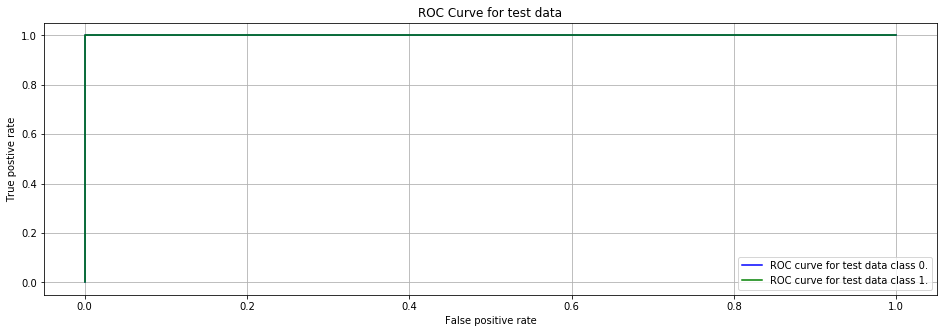

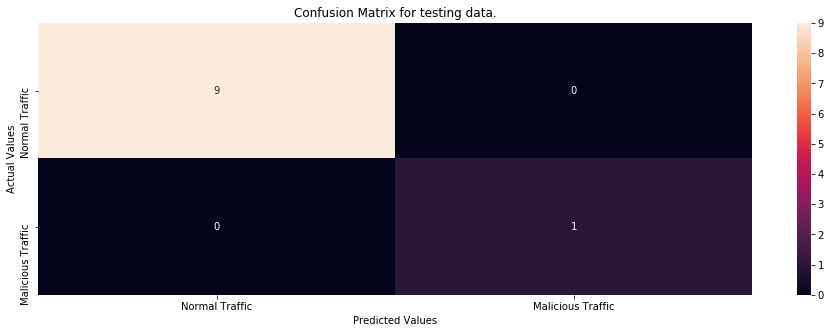

In [34]:
test_pred = final_fun_2(test_data, test_data_label)